### Multi-Layer Perceptron using Pytorch - CIFAR10 ###
1.Iswariya Manivannan<br>
2.Sathiya Ramesh

In [1]:
import torch
import skorch # A pytorch wrapper for using sklearn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dsets


from skorch.callbacks import WarmRestartLR, CyclicLR
from skorch.callbacks import LRScheduler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from skorch.callbacks import EpochScoring
from skorch import NeuralNetClassifier
from skorch import utils
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np

torch.manual_seed(40)
torch.cuda.manual_seed(40)
np.random.seed(2)

In [2]:
# Normalizing the output PIL Image of Torchvision dataset from [0,1] to [-1,1]
train_transform = transforms.Compose([
                                #transforms.RandomHorizontalFlip(),
                                #transforms.ColorJitter(brightness= 5, contrast= 5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=train_transform)
testset = dsets.CIFAR10('./data', train=False, download=True, transform=test_transform)


classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# Function to separate the data in trainset/testset as images and labels
def dataloader(dataset):
    images_labels = zip(*dataset)
    images_labels = list(images_labels)
    X = list(images_labels[0])
    y = list(images_labels[1])
    images = np.stack(X, axis =0)
    labels = np.asarray(y)

    images = np.reshape(images, (-1, 32*32*3))
    print(images.shape)
    
    return images, labels

In [4]:
X_train, y_train = dataloader(trainset)
X_test, y_test = dataloader(testset)

(50000, 3072)
(10000, 3072)


In [5]:
# 2 layer Logistic Regression Model which has 4 Hidden layers with Relu activation and an Output layer
class Multi_layer_perceptron(nn.Module):
    
    def __init__(self, input_dims, output_dims, dropout):
        
        super(Multi_layer_perceptron, self).__init__()
        self.linear1 = nn.Linear(input_dims, 2056)
        self.batchnorm1 = nn.BatchNorm1d(2056)
        
        self.dropout_input = nn.Dropout(dropout[0])
        self.dropout_hidden = nn.Dropout(dropout[1])
        
        self.linear2 = nn.Linear(2056, 1024)
        self.batchnorm2 = nn.BatchNorm1d(1024)

        self.linear3 = nn.Linear(1024, 1024)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        
        self.linear4 = nn.Linear(1024, 512)
        self.batchnorm4 = nn.BatchNorm1d(512)
        
        self.linear5 = nn.Linear(512, output_dims)

        self.relu = nn.ReLU()
    
        
    def forward(self, x):
        
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout_input(x)
        
        x = self.linear2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout_hidden(x)
        
        x = self.linear3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout_hidden(x)
        
        x = self.linear4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
 
        x = self.linear5(x)
        return  x

In [32]:
# Calculating Cross Entropy Loss
class CrossEntropyLoss(nn.Module):
    
    log_softmax = nn.LogSoftmax()
    
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
        
    def forward(self, logits, targets):
        
        log_softmax = nn.LogSoftmax(dim=1)
        log_probabilities = log_softmax(logits)  # Getting the log probabilities using log_softmax
        targets = targets.long()
        #loss = - log_probabilities.index_select(-1, targets).diag()
        loss = - log_probabilities.gather(1, targets.view(-1,1))  # Filtering out the log probabilities based on target class
        return torch.mean(loss)

In [9]:
# Calculating Hinge Loss
class HingeLoss(nn.Module):

    def __init__(self):

        super(HingeLoss, self).__init__()

        

    def forward(self, logits, targets):

        targets = targets.long()
        zeros = torch.tensor([0.])
        loss= torch.max(zeros,logits - logits.gather(1, targets.unsqueeze(1))+1)

        dim_array = torch.arange(0, targets.shape[0], out=torch.LongTensor())


        idx=(dim_array,targets) # tuple of Long tensor containing the indices of target class score
        
        loss.index_put_(idx, torch.tensor([0.]))# Replacing 0s in positions where the target score is subtracted from itself    

        return torch.mean(torch.sum(loss,dim=1))

We the use the following techniques to improve the model accuracy:
1. Dropout with a probability of 0.3
2. L2 regularization of $3e^-4$
3. Learning rate Decay using a learning rate schedular which utilizes the CyclicLR policy.
We chose the following values after several training instances because they gave the highest validation set accuracy of 58%.
4. Early stopping

In [39]:
input_dim = 32*32*3
output_dim = 10

#scheduler_clbk_warmrestarts = LRScheduler(policy = 'WarmRestartLR',  min_lr=1e-06, max_lr=0.0001)

scheduler_clbk_cyclic_lr = LRScheduler(policy = 'CyclicLR',  base_lr = 1e-06, max_lr = 0.0001, step_size = 2*50000//512)


model = NeuralNetClassifier(module = Multi_layer_perceptron, module__input_dims = input_dim, module__output_dims = output_dim,
                           max_epochs = 50, lr = 0.0001, batch_size = 512, module__dropout = [0.3, 0.3],
                           criterion = CrossEntropyLoss, optimizer = optim.Adam, callbacks = [scheduler_clbk_cyclic_lr],
                           optimizer__weight_decay = 3e-4, verbose = 2) 

# To use hinge loss, replace CrossEntropyLoss in criterion to HingeLoss

In [40]:
model.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.1828       0.3444        1.9447  35.7100
      2        1.8103       0.4212        1.6400  28.4168
      3        1.5889       0.4718        1.4940  23.3897
      4        1.4751       0.4933        1.4326  23.4591
      5        1.4281       0.4942        1.4195  29.0940
      6        1.4034       0.5076        1.3841  33.4610
      7        1.3495       0.5216        1.3383  33.4558
      8        1.2565       0.5342        1.3005  27.0931
      9        1.2119       0.5347        1.3089  23.2718
     10        1.2356       0.5325        1.3217  23.2829
     11        1.2007       0.5459        1.2843  23.2968
     12        1.0991       0.5525        1.2485  24.7119
     13        1.0668       0.5489        1.2826  23.2138
     14        1.1067       0.5402        1.3210  23.6584
     15        1.0759       0.5556        1.2765  23.2209
     16       

<class 'skorch.net.NeuralNetClassifier'>[initialized](
  module_=Multi_layer_perceptron(
    (linear1): Linear(in_features=3072, out_features=2056, bias=True)
    (batchnorm1): BatchNorm1d(2056, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout_input): Dropout(p=0.3)
    (dropout_hidden): Dropout(p=0.3)
    (linear2): Linear(in_features=2056, out_features=1024, bias=True)
    (batchnorm2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear3): Linear(in_features=1024, out_features=1024, bias=True)
    (batchnorm3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear4): Linear(in_features=1024, out_features=512, bias=True)
    (batchnorm4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear5): Linear(in_features=512, out_features=10, bias=True)
    (relu): ReLU()
  ),
)

In [41]:
# Getting predictions for testset data
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'Test set Accuracy : {accuracy*100}')

Test set Accuracy : 57.38999999999999


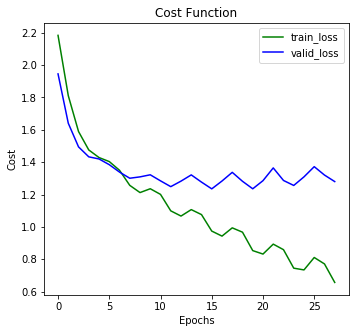

In [44]:
#Plotting learing curve
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1)
ax.set_title("Cost Function")
ax.plot(model.history[:,'train_loss'], '-', color='green')
ax.plot(model.history[:,'valid_loss'], '-', color='blue')
ax.set_xlabel("Epochs")
ax.set_ylabel("Cost")
ax.legend(['train_loss', 'valid_loss'])

In [42]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_test)
print(cm)

[[660  41  79  35  31  14  11  26  81  45]
 [ 25 636  12  10   4   3  10   3  49 139]
 [ 42  12 424  66  96  65  63  26  11  11]
 [ 13  28  89 398  66 235  83  68  32  34]
 [ 49  16 164  83 550  90  99 106  27  20]
 [ 10  11  67 173  46 434  28  70  14  15]
 [ 22  30  87 115  99  58 663  20   7  21]
 [ 25  26  52  70  73  66  16 643   8  52]
 [113  62  15  17  21  17  11   7 729  61]
 [ 41 138  11  33  14  18  16  31  42 602]]


('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


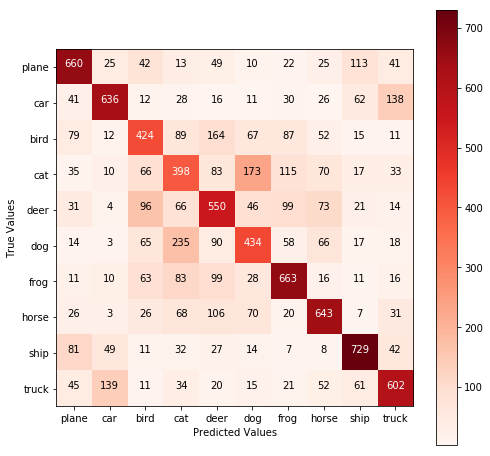

In [43]:
# Plotting confusion matrix
import itertools
def plot_confusion_matrix(cm, classes):
    
    cmap = plt.get_cmap('Reds')
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap = cmap, interpolation = 'nearest')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    print(classes)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    
    threshold = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(i, j, f'{cm[i, j]}' , horizontalalignment = 'center', 
                 color="white" if cm[i, j] > threshold else "black")

plot_confusion_matrix(cm, classes)

In [46]:
model.save_params("MLP_model.th")